In [77]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfTransformer,CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
import csv
from sklearn.metrics import classification_report,accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,roc_curve,auc

In [78]:
# read data
train_set = pd.read_json('dataset/train_set.json')
test_set = pd.read_json('dataset/test_set.json')

### Preprocess data

In [79]:
import re
import string
def clean_text(text):
    # to lower case
    text = text.lower()
    # remove links
    text = re.sub('https:\/\/\S+', '', text) 
    # remove punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) 
    # remove next line     
    text = re.sub(r'[^ \w\.]', '', text) 
    # remove words containing numbers
    text = re.sub('\w*\d\w*', '', text)
    
    return text
# Create a new column called "Text" for collecting clean text  df.OriginalTweet.apply(lambda x: clean_text(x))
train_set['Text'] = train_set.text.apply(lambda x: clean_text(x))

### Data split : training and test set

In [80]:
X = train_set['Text']
y = train_set['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

### Stemming of text

In [88]:
#Use NLTK's PorterStemmer
from nltk.stem.porter import PorterStemmer
porter_stemmer = PorterStemmer()
def stemming_tokenizer(str_input):
    words = re.sub(r"[^A-Za-z0-9\-]", " ", str_input).lower().split()
    words = [porter_stemmer.stem(word) for word in words]
    return words

In [89]:
classifier = Pipeline([('tfidf',  TfidfVectorizer(max_features=2000,tokenizer=stemming_tokenizer)),
                     ('clf', LogisticRegression())])

### Parameter search

In [90]:
from sklearn.model_selection import GridSearchCV
parameters_svm = {'tfidf__max_features': range(1000, 6000,500)
                 }
gs_clf_svm = GridSearchCV(classifier, parameters_svm, n_jobs=-1)
gs_clf_svm = gs_clf_svm.fit(X_train,y_train)
gs_clf_svm.best_score_
gs_clf_svm.best_params_

{'tfidf__max_features': 1500}

In [91]:
classifier = Pipeline([('tfidf',  TfidfVectorizer(max_features=1500)),
                     ('clf', LogisticRegression())])

### Train classifier 

In [92]:
clf = classifier.fit(X_train, y_train)

### Classifier inference

In [93]:
pred_labels = clf.predict(X_test)

In [94]:
print('accuracy is {}'.format(accuracy_score(y_test,pred_labels)))

accuracy is 0.635


### Confusion matrix 

In [95]:
C = confusion_matrix(y_test,pred_labels)
C = C / C.astype(np.float).sum(axis=1)

/home/denis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


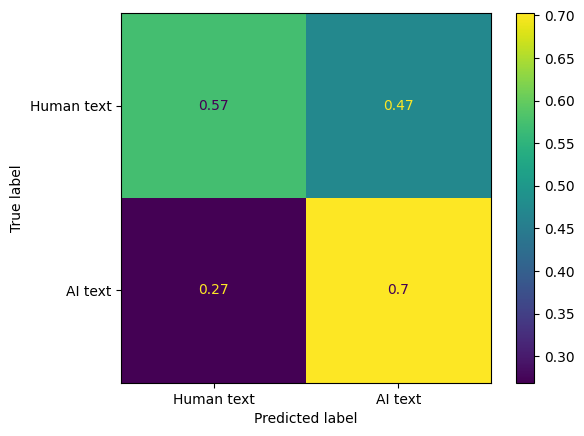

In [96]:
disp = ConfusionMatrixDisplay(confusion_matrix=C ,display_labels=['Human text','AI text'])
disp.plot()

### ROC curve for model

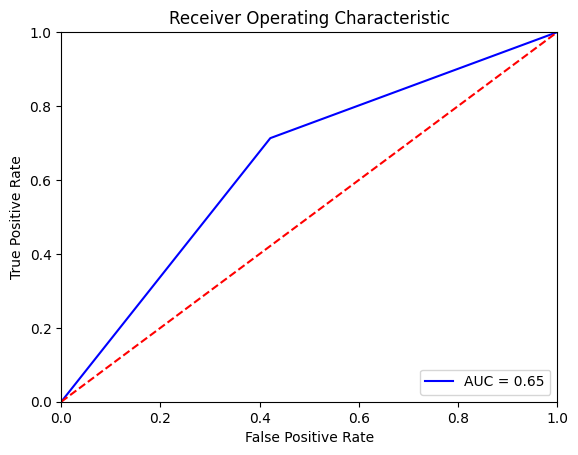

In [76]:
import matplotlib.pyplot as plt
fpr, tpr, threshold = roc_curve(y_test, pred_labels)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()